In [1]:
from re import A
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages


model_low_temp = ChatOpenAI(model='gpt-4o-mini', temperature=0.1)
model_high_temp = ChatOpenAI(model='gpt-4o-mini', temperature=0.9)

class State(TypedDict):
    # 대확 기록
    messages: Annotated[list, add_messages]

    # 입력
    user_query: str

    # 출력
    sql_query: str
    sql_explanation: str

class Input(TypedDict):
    user_query: str

class Output(TypedDict):
    sql_query: str
    sql_explanation: str

generate_prompt = SystemMessage(
    '당신은 친절한 데이터 분석가입니다. 사용자의 질문을 바탕으로 SQL 쿼리를 작성하세요.'
)

def generate_sql(state: State) -> State:
    user_message = HumanMessage(state['user_query'])
    messages = [generate_prompt, *state['messages'], user_message]
    res = model_low_temp.invoke(messages)

    return {
        'sql_query': res.content,
        # 대화 기록 업데이트
        'messages': [user_message, res]
    }

explain_prompt = SystemMessage(
    '당신은 친절한 데이터 분석가입니다. 사용자에게 SQL쿼리를 설명하세요.'
)

def explain_sql(state: State) -> State:
    messages = [
        explain_prompt,
        # 이전 단계의 사용자의 질문과 SQL 쿼리
        *state['messages'],
    ]
    res = model_high_temp.invoke(messages)

    return {
        'sql_explanation': res.content,
        # 대화 기록 업데이트
        'messages': res
    }


builder = StateGraph(State, input=Input, output=Output)

builder.add_node('generate_sql', generate_sql)
builder.add_node('explain_sql', explain_sql)

builder.add_edge(START, 'generate_sql')
builder.add_edge('generate_sql', 'explain_sql')
builder.add_edge('explain_sql', END)

graph = builder.compile()

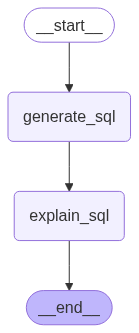

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({'user_query': '각 품목의 판매량을 구해주세요.'})

{'sql_query': '각 품목의 판매량을 구하기 위한 SQL 쿼리는 다음과 같습니다. 이 쿼리는 `sales`라는 테이블에서 `item`과 `quantity`라는 열을 가정하고 작성되었습니다. 실제 테이블 및 열 이름에 맞게 수정해 주세요.\n\n```sql\nSELECT item, SUM(quantity) AS total_sales\nFROM sales\nGROUP BY item;\n```\n\n이 쿼리는 각 품목별로 판매량의 합계를 계산하여 반환합니다.',
 'sql_explanation': '이 쿼리를 좀 더 자세히 설명해 드리겠습니다.\n\n1. **SELECT item, SUM(quantity) AS total_sales**:\n   - `SELECT` 구문은 우리가 조회하고자 하는 열을 선택하는 부분입니다.\n   - `item`은 각 품목을 나타내는 열입니다.\n   - `SUM(quantity)`는 `quantity` 열의 값들을 모두 더한 결과를 반환합니다. 이 합계를 `total_sales`라는 이름으로 표시합니다.\n\n2. **FROM sales**:\n   - `FROM` 구문은 데이터를 가져올 테이블을 지정합니다. 이 경우 `sales` 테이블에서 데이터를 가져옵니다.\n\n3. **GROUP BY item**:\n   - `GROUP BY` 구문은 특정 열의 값에 따라 결과를 그룹화하는 데 사용됩니다. 여기서는 `item`별로 각 품목의 판매량을 집계합니다.\n   - 즉, 같은 품목의 판매 데이터가 여러 개 있을 경우, 이들을 하나로 묶어서 판매량을 합산합니다.\n\n결과적으로 이 쿼리는 각 품목별로 총 판매량을 구해주는 역할을 하며, 각 품목과 그에 해당하는 판매량의 합계를 리스트 형태로 반환합니다.'}